# Customer Churn Prediction with Various ML Algorithms (Kaggle Asia Dataset)

## Importing packages, defining functions & configurations

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys,joblib
from sklearn import tree
import six

sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context("talk", font_scale = 0.65, rc = {"grid.linewidth": 5})

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from scipy.stats import skew
from fancyimpute import KNN
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#Function to plot accuracy metrics

def model_metrics(actual, predicted):

    confusion = confusion_matrix(actual, predicted)
    TP = confusion[1,1]
    TN = confusion[0,0]
    FP = confusion[0,1]
    FN = confusion[1,0]

    acc = round(accuracy_score(actual, predicted), 2)
    rcl = round(recall_score(actual, predicted), 2)
    roc = round(roc_auc_score(actual, predicted), 2)
    fpr = round(FP/float(TN + FP),2)
    spec = round(TN/float(TN + FP),2)

    metrics_df = pd.DataFrame(data = [[acc, roc, fpr, spec, rcl, TP, TN, FP, FN,]],
                              columns = ['Accuracy', 'ROC_AUC','FPR', 'Specificity', 'Recall Score', 'True Positive','True Negative', 'False Positive','False Negative'],
                              index = ['score'])
    return metrics_df


In [ ]:
# Plot Minutes of Usage & Month

def mou_w_month(data, col):

    fig, ax = plt.subplots(figsize = (7,4))

    colList=list(data.filter(regex = (col)).columns)[:3]

    plt.plot(df.groupby('churn')[colList].mean().T)
    ax.set_xticklabels(['Jun', 'Jul', 'Aug', 'Sep'])

    plt.legend(['Non-Churn', 'Churn'])
    plt.title( str(col) + " vs Month", loc = 'left', color='black')
    plt.xlabel("Month")
    plt.ylabel(col)

    plt.show()

In [ ]:
# Describe the % of NULL values in the dataframe columns

def null_percentage(df):

    nums = df[df.columns].isna().sum().sort_values(ascending = False)
    perc = (df[df.columns].isna().sum()/len(df)*100).sort_values(ascending = False)

    missing = pd.concat([nums, perc], keys = ['Total','Percentage'], axis = 1)
    missing = missing[missing['Percentage']>0]

    return missing

In [ ]:
# List of columns that have 95% of values same

def redundant(df):
    redundant = []

    for i in df.columns:
        counts = df[i].value_counts()
        maxc = counts.iloc[0]
        if (maxc / len(df)) > 0.95:
            redundant.append(i)

    return list(redundant)


In [ ]:
#Function to impute NaN with 0

def imputeNaN(df, col_name):
    for col in col_name:
        df[col].fillna(0, inplace = True)


## Reading the dataset

In [ ]:
df = pd.read_csv('/input/telecom_churn_data.csv')
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4.0,

Check percentage of NULL values

In [ ]:
# Number of columns having null values
len(null_percentage(df))

219


## Data Preparation

### Data transformation

In [ ]:
# New = Total recharge amount data

df['tot_rech_amt_data_6'] = df['total_rech_data_6'] * df['av_rech_amt_data_6']
df['tot_rech_amt_data_7'] = df['total_rech_data_7'] * df['av_rech_amt_data_7']
df['tot_rech_amt_data_8'] = df['total_rech_data_8'] * df['av_rech_amt_data_8']
df['tot_rech_amt_data_9'] = df['total_rech_data_9'] * df['av_rech_amt_data_9']

# New column = Total amount per month

df['tot_amt_6'] = df[['total_rech_amt_6','tot_rech_amt_data_6']].sum(axis = 1)
df['tot_amt_7'] = df[['total_rech_amt_7','tot_rech_amt_data_7']].sum(axis = 1)
df['tot_amt_8'] = df[['total_rech_amt_8','tot_rech_amt_data_8']].sum(axis = 1)
df['tot_amt_9'] = df[['total_rech_amt_9','tot_rech_amt_data_9']].sum(axis = 1)

# Average - June/July
df['avg_amt_6_7'] = df[['tot_amt_6','tot_amt_7']].mean(axis=1)

df.drop(['tot_rech_amt_data_6','tot_rech_amt_data_7','tot_rech_amt_data_8','tot_rech_amt_data_9'], inplace = True, axis = 1)

In [ ]:
catg= []

for col in df.columns:
    if len(df[col].unique()) == 2 | 3:
        catg.append(col)

df[catg] = df[catg].apply(lambda x:x.astype('object'))
col_tmp = ['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9']

df[col_tmp] = df[col_tmp].apply(lambda x:x.astype('object'))

### Dimensionality reduction

In [ ]:
df = df.drop(redundant(df), axis = 1)
df.shape

(19860, 161)

### Data Imputation

KNN Imputation & impute NaN with 0

In [ ]:
cols= null_percentage(df)[null_percentage(df)['Percentage'] > 40].index
imputeNaN(df, cols)

In [ ]:
imp_cols = list(set(null_percentage(df).index)-set(('date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8')))

knn_imp = KNNImputer()
df[imp_cols] = knn_imp.fit_transform(df[imp_cols])

In [ ]:
null_percentage(df)

,Total,Percentage
date_of_last_rech_8,731,3.680765
date_of_last_rech_7,377,1.898288
date_of_last_rech_6,339,1.706949


In [ ]:
df.fillna(0, inplace=True)

In [ ]:
len(df['mobile_number'].unique())

19860

### Categorize Churned Customers

Customers who have not used any service (calls or internet) in the 9th month are considered to have churned

In [ ]:
df['churn'] = np.where(df[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].sum(axis = 1) == 0, 1, 0)
df.drop(df.filter(regex = '_9|sep', axis = 1).columns, axis = 1,inplace = True)

0    17795
1     2065
Name: churn, dtype: int64

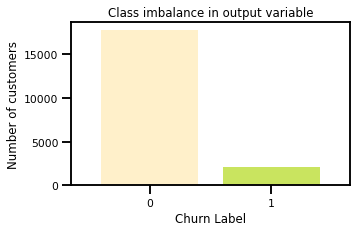

In [ ]:
# Churn Percentage

fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)

r = df['churn'].value_counts()

r.plot(kind = 'bar', ax = ax, color = ['#FFF0CA','#C9E45F'], width = 0.8)

ax.set_title('Class imbalance in output variable')
ax.set_xlabel('Churn Label')
ax.set_ylabel('Number of customers')
ax.tick_params(rotation = 'auto')

df['churn'].value_counts()

### Feature Engineering

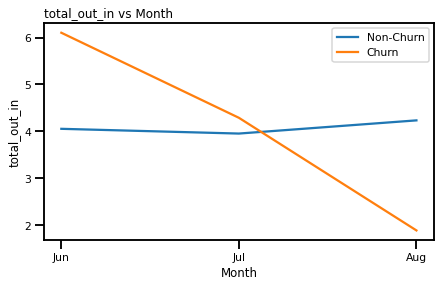

In [ ]:
# Total outgoing call: Total incoming calls minutes of usage

for i in range(6, 9):
    df['total_out_in' + str(i)] = (df['total_og_mou_' + str(i)])/(df['total_ic_mou_' + str(i)] + 1)

mou_w_month(df, 'total_out_in')

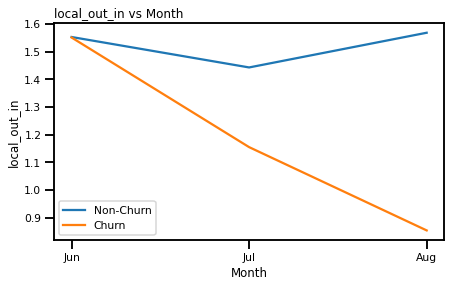

In [ ]:
# Local outgoing call: Local incoming calls minutes of usage

for i in range(6, 9):
    df['local_out_in' + str(i)] = (df['loc_og_mou_' + str(i)])/(df['loc_ic_mou_' + str(i)] + 1)

mou_w_month(df, 'local_out_in')

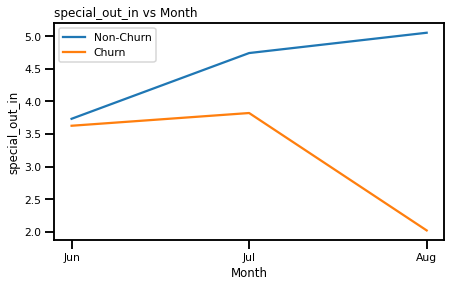

In [ ]:
# Special outgoing call: Local incoming calls minutes of usage

for i in range(6, 9):
    df['special_out_in' + str(i)] = (df['spl_og_mou_' + str(i)])/(df['spl_ic_mou_' + str(i)] + 1)

mou_w_month(df, 'special_out_in')

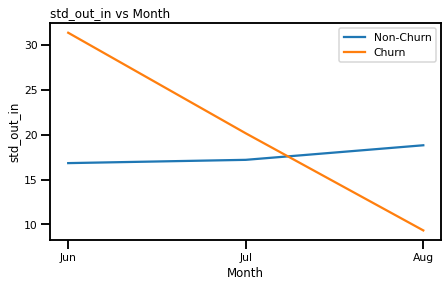

In [ ]:
# Std outgoing call: Local incoming calls minutes of usage

for i in range(6, 9):
    df['std_out_in' + str(i)] = (df['std_og_mou_' + str(i)])/(df['std_ic_mou_' + str(i)] + 1)

mou_w_month(df, 'std_out_in')

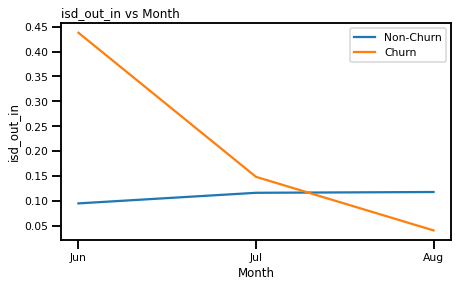

In [ ]:
# ISD outgoing call: Local incoming calls minutes of usage

for i in range(6, 9):
    df['isd_out_in' + str(i)] = (df['isd_og_mou_' + str(i)])/(df['isd_ic_mou_' + str(i)] + 1)

mou_w_month(df, 'isd_out_in')

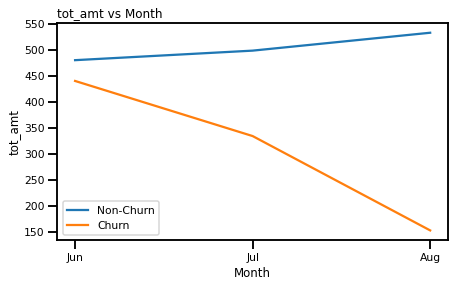

In [ ]:
mou_w_month(df,'tot_amt')

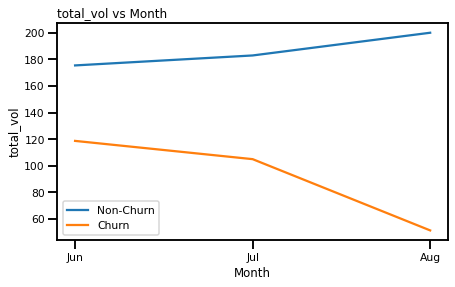

In [ ]:
# New = 2G + 3G

for i in range(6, 9):
    df['total_vol_' + str(i)] = df['vol_2g_mb_' + str(i)] + df['vol_3g_mb_'+str(i)]

mou_w_month(df, 'total_vol')

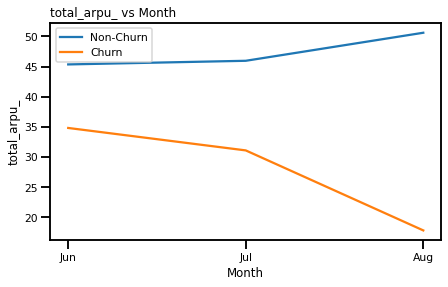

In [ ]:
# ARPU (Average Revenue Per User) from 2G and 3G

for i in range(6, 9):
    df['total_arpu_' + str(i)] = df['arpu_3g_'+str(i)] + df['arpu_3g_' + str(i)]

mou_w_month(df, 'total_arpu_')

In [ ]:
date_cols=['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], format = '%m/%d/%Y', errors = 'coerce')

In [ ]:
# Recent recharge date
cols = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
df['last_rech_date'] = df[cols].max(axis=1)

df['days_since_last_rech'] = np.floor(( pd.to_datetime('2014-08-31',format='%Y-%m-%d') - df['last_rech_date'] ).astype('timedelta64[D]'))

df['rech_weightage'] = len(cols) - (df[cols].isnull().sum(axis=1))
df.drop(['last_rech_date','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1, inplace=True)

cols = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']
df['last_rech_data_date'] = df[cols].max(axis=1)

df['days_since_last_data_rech'] = np.floor(( pd.to_datetime('2014-08-31',format='%Y-%m-%d') - df['last_rech_data_date'] ).astype('timedelta64[D]'))
df['days_since_last_data_rech'] = df['days_since_last_data_rech'].fillna(0)

df['rech_data_weightage'] = len(cols) - (df[cols].isnull().sum(axis=1))

df = df.drop(['last_rech_data_date','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'], axis=1)

In [ ]:
catg =['night_pck_user_6','monthly_2g_6','sachet_2g_6','monthly_3g_6','fb_user_6',
       'night_pck_user_7','monthly_2g_7','sachet_2g_7','monthly_3g_7','fb_user_7']
num_col = list(set(df.columns).difference(set(catg)))

In [ ]:
col_list = df.select_dtypes(include=['float64','int64']).filter(regex='_6|_7').drop(catg[:12],axis=1).drop(['avg_amt_6_7','og_others_6'],axis=1).columns.str[:-2]

for idx, col in enumerate(col_list.unique()):
    col_name = 'avg67_' + col
    col6 = col+'_6'
    col7 = col+'_7'
    df[col_name] = round((df[col6]  + df[col7])/ 2,2)

In [ ]:
col_list1 = df.select_dtypes(include = ['float64', 'int64']).filter(regex='avg67_').columns
col_list2 = df.select_dtypes(include = ['float64', 'int64']).filter(regex = '_8').drop(['fb_user_8','night_pck_user_8'], axis = 1).columns
for col1,col2 in zip(col_list1,col_list2):
    col_name = col2[:-2]+'_avgdiff8'
    df[col_name] = df[col2]-df[col1]


In [ ]:
col_list = df.select_dtypes(include=['float64','int64']).filter(regex='_6|_7').drop(catg[:12], axis = 1).drop(['avg_amt_6_7','og_others_6'], axis = 1).columns
df.drop(col_list,axis=1,inplace = True)
num_col = list(set(df.columns).difference(set(catg)))

###  Handling Skew

In [ ]:
df_numerical=df[num_col]

skewft = df_numerical.apply(lambda x: skew(x)).sort_values(ascending = False)
high_skew = skewft[skewft > 0.5]
skewness = pd.DataFrame({'Skew' :high_skew})

# Display Skewn
pd.DataFrame(skewft,columns = ['Skewness']).head(10)

,Skewness
og_others_8,110.929432
local_out_in8,88.173781
local_out_in6,74.618608
isd_out_in6,69.499989
isd_out_in7,64.729798
total_out_in8,50.325518
isd_out_in8,47.526303
total_out_in6,47.222269
local_out_in7,46.873567
ic_others_8,39.392712


In [ ]:
num_col.remove('churn')
qt = QuantileTransformer()
df[num_col] = qt.fit_transform(df[num_col])

### Handling Imbalance Dataset

In [ ]:
X = df.drop('churn',axis=1)
y = df['churn']

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace = True)

In [ ]:
def oversample(X,y):

  sm = SMOTE(random_state=42)
  X_over, y_over = sm.fit_resample(X, y)

  X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.30, random_state=0)

  return [X_train, X_test, y_train, y_test]

In [ ]:
def undersample(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  rus = RandomUnderSampler(random_state=0)
  X_under, y_under = rus.fit_resample(X_train, y_train)

  return [X_under, X_test, y_under, y_test]

### Scaling

In [ ]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

# Normalization

def scaling(X_train, X_test):

  scaler=StandardScaler()
  X_train=scaler.fit_transform(X_train)
  X_test=scaler.transform(X_test)

  return [X_train, X_test]

### Applying PCA

In [ ]:
pca = PCA(n_components = 70, random_state = 42, svd_solver = 'randomized')
X_pca = pca.fit_transform(X)

In [ ]:
def apply_pca(X_train, X_test):

  # PCA 0.9 variance or 90% information
  pca = PCA(0.9)
  df_train = pca.fit_transform(X_train)
  df_train.shape

  # Intializing PCA with n_components=61
  pca = PCA(n_components = 70, random_state = 42, svd_solver='randomized')
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  return [X_train_pca,X_test_pca]

## Naive Bayes Classifier

In [ ]:
def execute_nb(X_train, X_test, y_train, y_test):

  gnb = GaussianNB()
  gnb.fit(X_train,y_train)

  y_test_pred = gnb.predict(X_test)

  print('Classification Report:\n')
  print(classification_report(y_test, y_test_pred))

  model_metrics(y_test, y_test_pred)

In [ ]:
def nb_all(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("WITHOUT PCA:")

  print("\nNaive Bayes - Without sampling:")
  X_train, X_test = scaling(X_train, X_test)
  execute_nb(X_train, X_test, y_train, y_test)

  print("\nNaive Bayes - Undersampling:")
  X_train, X_test, y_train, y_test = undersample(X,y)
  X_train, X_test = scaling(X_train, X_test)
  execute_nb(X_train, X_test, y_train, y_test)

  print("\nNaive Bayes - Oversampling:")
  X_train, X_test, y_train, y_test = oversample(X,y)
  X_train, X_test = scaling(X_train, X_test)
  execute_nb(X_train, X_test, y_train, y_test)

  print("\nWITH PCA:")

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("\nNaive Bayes - without any sampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_nb(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = undersample(X,y)
  print("\nNaive Bayes - Undersampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_nb(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = oversample(X,y)
  print("\nNaive Bayes - Oversampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_nb(X_train, X_test, y_train, y_test)

In [ ]:
nb_all(X,y)


NB - without PCA:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85      5149
         1.0       0.21      0.76      0.33       447

    accuracy                           0.76      5596
   macro avg       0.59      0.76      0.59      5596
weighted avg       0.91      0.76      0.81      5596


NB - without any sampling:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      5149
         1.0       0.54      0.57      0.56       447

    accuracy                           0.93      5596
   macro avg       0.75      0.77      0.76      5596
weighted avg       0.93      0.93      0.93      5596


NB - Undersampling:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.70      0.82      5149
         1.0       0.18      0.78      0.30       447

    accuracy                           0.7

## KNN

In [ ]:
def execute_knn(X_train, X_test, y_train, y_test):
  knn = KNeighborsClassifier()
  knn.fit(X_train,y_train)
  y_test_pred = knn.predict(X_test)
  print('Classification Report:\n')
  print(classification_report(y_test,y_test_pred))

  model_metrics(y_test,y_test_pred)

In [ ]:
def knn_all(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("WITHOUT PCA:")

  print("\nKNN - Without sampling:")
  X_train, X_test = scaling(X_train, X_test)
  execute_knn(X_train, X_test, y_train, y_test)

  print("\nKNN - Undersampling:")
  X_train, X_test, y_train, y_test = undersample(X,y)
  X_train, X_test = scaling(X_train, X_test)
  execute_knn(X_train, X_test, y_train, y_test)

  print("\nKNN - Oversampling:")
  X_train, X_test, y_train, y_test = oversample(X,y)
  X_train, X_test = scaling(X_train, X_test)
  execute_knn(X_train, X_test, y_train, y_test)

  print("\nWITH PCA:")

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("\nKNN - without any sampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_knn(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = undersample(X,y)
  print("\nKNN - Undersampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_knn(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = oversample(X,y)
  print("\nKNN - Oversampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_knn(X_train, X_test, y_train, y_test)

In [ ]:
knn_all(X,y)


KNN - without PCA:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      5149
         1.0       0.60      0.38      0.47       447

    accuracy                           0.93      5596
   macro avg       0.78      0.68      0.72      5596
weighted avg       0.92      0.93      0.92      5596


KNN - without any sampling:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      5149
         1.0       0.63      0.41      0.49       447

    accuracy                           0.93      5596
   macro avg       0.79      0.69      0.73      5596
weighted avg       0.92      0.93      0.93      5596


KNN - Undersampling:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      5149
         1.0       0.31      0.78      0.44       447

    accuracy                           

## SVM

In [ ]:
def execute_svm(X_train, X_test, y_train, y_test):

  svc = SVC(random_state = 42, class_weight = 'balanced')
  svc.fit(X_train, y_train)

  y_test_pred = svc.predict(X_test)

  print('Classification Report:\n')
  print(classification_report(y_test, y_test_pred))
  model_metrics(y_test, y_test_pred)

In [ ]:
def svm_all(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("WITHOUT PCA:")

  print("\nSVM - Without sampling:")
  X_train, X_test = scaling(X_train, X_test)
  execute_svm(X_train, X_test, y_train, y_test)

  print("\nSVM - Undersampling:")
  X_train, X_test, y_train, y_test = undersample(X,y)
  X_train, X_test = scaling(X_train, X_test)
  execute_svm(X_train, X_test, y_train, y_test)

  print("\nSVM - Oversampling:")
  X_train, X_test, y_train, y_test = oversample(X,y)
  X_train, X_test = scaling(X_train, X_test)
  execute_svm(X_train, X_test, y_train, y_test)

  print("\nWITH PCA:")

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("\nSVM - without any sampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_svm(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = undersample(X,y)
  print("\nSVM - Undersampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_svm(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = oversample(X,y)
  print("\nSVM - Oversampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_svm(X_train, X_test, y_train, y_test)

In [ ]:
svm_all(X,y)


SVM - without PCA:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      5149
         1.0       0.49      0.76      0.59       447

    accuracy                           0.92      5596
   macro avg       0.73      0.84      0.77      5596
weighted avg       0.94      0.92      0.93      5596


SVM - without any sampling:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      5149
         1.0       0.46      0.78      0.58       447

    accuracy                           0.91      5596
   macro avg       0.72      0.85      0.77      5596
weighted avg       0.94      0.91      0.92      5596


SVM - Undersampling:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      5149
         1.0       0.37      0.83      0.51       447

    accuracy                           

## Decision Tree

In [ ]:
def execute_dt(x_col, x_test, y_col, y_test):
  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(x_col, y_col)

  y_pred = clf.predict(x_test)

  print("Classification Report:\n")
  print(classification_report(y_test, y_pred))

In [ ]:
def dt_all(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("WITHOUT PCA:")

  print("\nDecision Tree - Without sampling:")
  X_train, X_test = scaling(X_train, X_test)
  execute_dt(X_train, X_test, y_train, y_test)

  print("\nDecision Tree - Undersampling:")
  X_train, X_test, y_train, y_test = undersample(X,y)
  X_train, X_test = scaling(X_train, X_test)
  execute_dt(X_train, X_test, y_train, y_test)

  print("\nDecision Tree - Oversampling:")
  X_train, X_test, y_train, y_test = oversample(X,y)
  X_train, X_test = scaling(X_train, X_test)
  execute_dt(X_train, X_test, y_train, y_test)

  print("\nWITH PCA:")

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

  print("\nDecision Tree - without any sampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_dt(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = undersample(X,y)
  print("\nDecision Tree - Undersampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_dt(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = oversample(X,y)
  print("\nDecision Tree - Oversampling:")
  X_train, X_test = scaling(X_train, X_test)
  X_train, X_test = apply_pca(X_train, X_test)
  execute_dt(X_train, X_test, y_train, y_test)

In [ ]:
dt_all(X, y)


Decision Tree- without PCA:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      5149
         1.0       0.44      0.49      0.46       447

    accuracy                           0.91      5596
   macro avg       0.70      0.72      0.71      5596
weighted avg       0.91      0.91      0.91      5596


Decision Tree - without any sampling:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      5149
         1.0       0.34      0.43      0.38       447

    accuracy                           0.89      5596
   macro avg       0.65      0.68      0.66      5596
weighted avg       0.90      0.89      0.89      5596


Decision Tree - Undersampling:
Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83      5149
         1.0       0.19      0.76      0.31       447

    accura